In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure3 import cv_pre, cm_pre, plotR2YQ2Y, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages, plotGridSearch
from msresist.clustering import MassSpecClustering
import matplotlib.pyplot as plt
from msresist.pre_processing import preprocessing
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## Re-implementation with AXL mutants

### Phosphorylation measurements:

#### + Erlotinib + AXL-activating Antibody (AF154)

In [3]:
X = preprocessing(Axlmuts_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

all_lines = ["PC9", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"] 
mut_lines = all_lines[1:]
g_lines = all_lines[2:]

d.index = all_lines

0/771 peptides were not found in the proteome.
771


### Phenotypes of AXL mutants

#### Cell Viability

In [4]:
all_lines = ["PC9-A/E", "AXL KO-A/E", "Kdead-A/E", "Kin-A/E", "M4-A/E", "M5-A/E", "M7-A/E", "M10-A/E", "M11-A/E", "M15-A/E"]
lines = all_lines[1:]
glines = lines[2:]

In [5]:
cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR1_Phase.csv")
cv2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR2_Phase.csv")
cv3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv")

itp = 12
ftp = 120
tr = 'A/E'

v = cv_pre(cv1, cv2, cv3, tr, itp, ftp, all_lines)

In [6]:
v

lines
PC9-A/E       7.246282
AXL KO-A/E    2.375132
Kdead-A/E     3.653204
Kin-A/E       5.444662
M4-A/E        4.629951
M5-A/E        4.688294
M7-A/E        6.010366
M10-A/E       5.538995
M11-A/E       5.962925
M15-A/E       4.055604
Name: viability, dtype: float64

#### Cell Death

#### Cell Migration

In [7]:
all_lines = ["PC9 A/E", "KO A/E", "KD A/E", "KIN A/E", "M4 A/E", "M5 A/E", "M7 A/E", "M10 A/E", "M11 A/E", "M15 A/E"]
lines = all_lines[1:]
glines = all_lines[2:]

In [8]:
rwd = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/03062020-AXLmuts_EMT_RWD_Collagen_BR1.csv")
rwdg = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/03062020-AXLmuts_EMT_GreenRWD_Collagen_BR1.csv")
wc = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/03062020-AXLmuts_EMT_WC_Collagen_BR1.csv")

ftp = 24

m = cm_pre(rwd, tr, ftp, all_lines)
m.index = v.index

In [9]:
m

lines
PC9-A/E       94.584855
AXL KO-A/E    54.870760
Kdead-A/E     66.549360
Kin-A/E       96.111215
M4-A/E        91.605670
M5-A/E        85.836235
M7-A/E        87.085310
M10-A/E       82.729170
M11-A/E       79.769890
M15-A/E       66.557255
Name: 12, dtype: float64

#### Build Y Matrix

In [10]:
y = pd.concat([v, m], axis=1)
y.columns = ["Viability", "Migration"]

y

,Viability,Migration
lines,,
PC9-A/E,7.246282,94.584855
AXL KO-A/E,2.375132,54.870760
Kdead-A/E,3.653204,66.549360
Kin-A/E,5.444662,96.111215
M4-A/E,4.629951,91.605670
M5-A/E,4.688294,85.836235
M7-A/E,6.010366,87.085310
M10-A/E,5.538995,82.729170
M11-A/E,5.962925,79.769890


# Co-clustering and PLSR model

## Cross-validation Strategy 1: Leaving one condition out across fixed clusters

### Fitting PLSR each time

In [21]:
distance_method = "PAM250"
ncl = 7
GMMweight = 2

MSC = MassSpecClustering(i, ncl, GMMweight=GMMweight, distance_method=distance_method).fit(d, y)
centers = MSC.transform(d)

Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0


AssertionError: 

#### R2Y/Q2Y

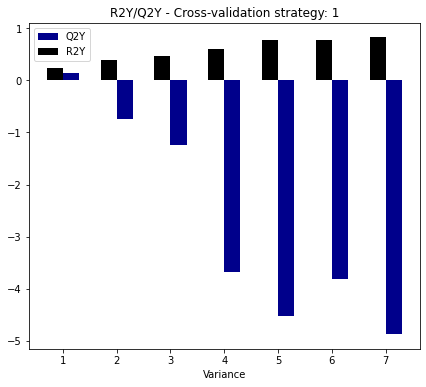

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plsr = PLSRegression(n_components=2)
plotR2YQ2Y(ax, plsr, centers, y, 1, ncl+1)

#### Measured vs Predicted

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plotMeasuredVsPredicted(ax, plsr, centers, y)

#### Scores & Loadings

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
plotScoresLoadings(ax, plsr.fit(centers, y), centers, y, ncl, all_lines, 1)

In [ ]:
# MSC.clustermembers(X.T).head()

#### Cluster Averages

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plotclusteraverages(ax, MSC.transform(d).T, all_lines)

## Cross-validation Strategy 2: Across entire pipeline

### Fitting entire model pipeline each time

In [ ]:
ncomp = 2

CoCl_plsr = Pipeline([('CoCl', MassSpecClustering(i, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = CoCl_plsr.fit(d, y)
centers = CoCl_plsr.named_steps.CoCl.transform(d)

#### R2Y/Q2Y

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# plotR2YQ2Y(ax, CoCl_plsr, d, y, cv=2, b=ncl+1)

#### GridSearch

Run:

In [ ]:
# scores = MSclusPLSR_tuning(d, i, y, "Binomial")

# scores = pd.DataFrame(scores)
# hp = scores.sort_values(by="mean_test_scores", ascending=False)
# hp.insert(0, "Ranking", list(np.arange(1, hp.shape[0]+1)))
# hp2 = scores[scores["#Components"]==2].sort_values(by="mean_test_scores", ascending=False)
# hp2.insert(0, "Ranking", list(np.arange(1, hp2.shape[0]+1)))

Import:

In [ ]:
gs = pd.read_csv("msresist/data/Model/20200320-GridSearch_pam250_CVWC_wPC9.csv")

In [ ]:
gs[gs["#Components"] == 2].head(10)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotGridSearch(ax, gs)

#### Measured vs Predicted

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
plotMeasuredVsPredicted(ax, CoCl_plsr, d, y)

#### Scores & Loadings

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, y, ncl, all_lines, 2)

In [ ]:
clustermembers = CoCl_plsr.named_steps.CoCl.clustermembers(X.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")

#### Cluster Averages

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plotclusteraverages(ax, centers.T, all_lines)